In this Notebook I am implementing following ML-Algorithms from scratch in pure python without using sklearn or any other similar packages and along with explanations for each of these algorithms.

#### 1. TFIDF
#### 2. GridSearchCV
#### 3. RandomSearchCV
#### 4. Decision Function of SVM RBF Kernel
#### 5. Platt Scaling to find P(Y==1|X)
#### 6. SGD Classifier with Logloss and L2 regularization


---

# TFIDF Vectorizer from Scratch without sklearn & compare its results with Sklearn

1. First Some basics on TF-IDF
2. fit() Method
3. Sklearn Implementation
4. Implement max features functionality

First Some basics on TF-IDF

Tf-idf stands for term frequency-inverse document frequency, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

    
One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.
    
Tf-idf can be successfully used for stop-words filtering in various subject fields including text summarization and classification.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

TF: Term Frequency, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

$$TF(t) = \frac{\text{Number of times term t appears in a document}}{\text{Total number of terms in the document}}.$$

Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following:

$$IDF(t) = \log_{e}\frac{\text{Total  number of documents}} {\text{Number of documents with term t in it}}.$$

for numerical stabiltiy we will be changing this formula little bit

$$IDF(t) = \log_{e}\frac{\text{Total  number of documents}} {\text{Number of documents with term t in it}+1}.$$

Example


Consider a document containing 100 words wherein the word cat appears 3 times. The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.

---

Here I will implement a TFIDF vectorizer on a collection of text documents and then compare the results of my own implementation of TFIDF vectorizer with that of sklearns implemenation TFIDF vectorizer.

     Sklearn does few more tweaks in the implementation of its version of TFIDF vectorizer, so to replicate the exact results I would need to add following things to our custom implementation of tfidf vectorizer:

         - Sklearn has its vocabulary generated from idf sorted in alphabetical order
         
         - Sklearn formula of idf is different from the standard textbook formula. Here the constant "1" is added to the numerator and denominator of the idf as if an extra document was seen containing every term in the collection exactly once, which prevents zero divisions.

 $$IDF(t) = 1+\log_{e}\frac{1\text{ }+\text{ Total  number of documents in collection}} {1+\text{Number of documents with term t in it}}.$$

         - Sklearn applies L2-normalization on its output matrix.
         - The final output of sklearn tfidf vectorizer is a sparse matrix.


 Steps to approach this problem :

 - I would have to write both fit and transform methods for my custom implementation of tfidf vectorizer.

 - Print out the alphabetically sorted voacb after I fit our data and check if its the same as that of the feature names from sklearn tfidf vectorizer.


 - Print out the idf values from our implementation and check if its the same as that of sklearns tfidf vectorizer idf values.
 -        Once I get our voacb and idf values to be same as that of sklearns implementation of tfidf vectorizer, proceed to the below steps.
 -       Make sure the output of our implementation is a sparse matrix. Before generating the final output, I need to normalize our sparse matrix using L2 normalization. You can refer to this link https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html

 -      After completing the above steps, print the output of our custom implementation and compare it with sklearns implementation of tfidf vectorizer.
 -      To check the output of a single document in our collection of documents,  I can convert the sparse matrix related only to that document into dense matrix and print it.

### The output of our custom implementation and that of sklearns implementation would match only with the collection of document strings I define below, as reference in this notebook. It would not match for strings that contain capital letters or punctuations, etc, because sklearn version of tfidf vectorizer deals with such strings in a different way.

In [1]:
from collections import Counter
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import random

corpus_1 = [
     'this is the first document',
     'this document is the second document',
     'and this is the third one',
     'is this the first document',
]

## fit() Method

 - With this function, we will find all unique words in the data and assign a dimension-number to each unique word.
 - So will define a python dictionary to store all the unique words, such that the key of dictionary represents a unique word and the corresponding value represent it's dimension-number.
 - For example, if a review says, 'very good taste' - then I can represent each unique word with a dimension_number as,

        { 'very' : 1, 'good' : 2, 'taste' : 3}

- And remember our dataset is a list of string

In [2]:
# Input : set of documents
# Output: word, dimension number pair for each word as a python dictionary
def fit_custom(dataset):
  unique_words = []
  for row in dataset:
    for word in row.split(" "):
      if len(word)>=2 and word not in unique_words:
        unique_words.append(word) # Add each unique word of length>2 to the list
  unique_words.sort()
  word_dimension_dict = {j:i for i,j in enumerate(unique_words)} # Enumerate the list, i.e., give consecutive numbers to each item, store in a dict
  return word_dimension_dict

word_dimension_dict = fit_custom(corpus_1)
# print(word_dimension_dict)

In [3]:
# Defining an utility Function to calculate the number of times a word appears in a whole dataset
def count_of_word_in_whole_dataset(dataset, word):
  count = 0
  for row in dataset:
    if word in row:
      count = count+1
  return count

In [4]:
# TRANSFROM METHOD
# Input : set of documents, word_dimension_dict from fit_custom() ; Output : TF-count_of_word_in_whole_dataset Matrix
def transform_custom(dataset, word_dimension_dict):
  rows = []
  columns = []
  values = []
  tf_val = []
  idf_val = []
  for idx, row in enumerate(dataset): # for each document in the dataset
    # it will return a dict type object where key is the word and values is its frequency, {word:frequency}
    word_freq = dict(Counter(row.split()))
    # for every unique word in the document
    for word, freq in word_freq.items():
      if len(word) < 2:
        continue
      # we will check if its there in the word_dimension_dictionary that we build in fit_custom() function
      # dict.get() function will return the values, if the key doesn't exits it will return -1
      col_index = word_dimension_dict.get(word, -1) # retrieving the dimension number of a word
      if col_index!=-1:
        # we are storing the index of the document
        rows.append(idx)
        # we are storing the dimensions of the word
        columns.append(col_index)
        # computes TF value for each word, freq of each word / total words in a document
        # computes count_of_word_in_whole_dataset value for each word=log(total no. of docus / no. of times a word is present in a doc via count_of_word_in_whole_dataset()

        # Now just multiply TF with count_of_word_in_whole_dataset
        # Below formulae to exactly replicate sklearn's formulae for tf-df calculation
        # See - https://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction
        # If ``smooth_idf=True`` (the default), the constant "1" is added to the
        # numerator and denominator of the idf as if an extra document was seen
        # containing every term in the collection exactly once, which prevents
        # zero divisions: idf(t) = log [ (1 + n) / (1 + df(t)) ] + 1.
        # https://github.com/scikit-learn/scikit-learn/blob/master/sklearn/feature_extraction/text.py#L1340
        tf_idf_value = (freq/len(row.split()))*(1 + (  np.log( (1 + len(dataset) ) / (1 + count_of_word_in_whole_dataset(dataset, word) ))))

        # but if smooth_idf=False then the following formulae would have been applied
        # val = (freq/len(row.split()))*(1 + (  np.log( (int(len(dataset)) ) / (count_of_word_in_whole_dataset(dataset, word) ))))

        values.append(tf_idf_value)

        sparse_matrix = csr_matrix((values, (rows,columns)), shape=(len(dataset), len(word_dimension_dict)))

        # As noted earlier, in sk-learn this output is normalized using L2 normalization. sklearn does this by default.
        # So we have to do that as well to match with sk-learn
        # normalize() function will apply ‘l2’, normalization by default
        # The 'norm' parameter to use to normalize each non zero sample
        # (or each non-zero feature if axis is 0).
        # https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization
        final_normalized_output = normalize(sparse_matrix)

  return final_normalized_output


In [5]:
tf_idf_vectorized_custom = transform_custom(corpus_1, word_dimension_dict)

# As the final output of sklearn tf-idf vectorizer is a sparse matrix to save storage space
# To visually understand the output better, we need to convert the sparse output matrix to dense matrix with toarray()
print(tf_idf_vectorized_custom.toarray())

# Even more clear way to visually inspect the output is to convert it to a pandas dataframe
# So below I will convert that to a dataframe and then use todense()
custom_tf_idf_output = tf_idf_vectorized_custom[0]
df_custom_tf_idf = pd.DataFrame(custom_tf_idf_output.T.todense(),  index=word_dimension_dict.keys(), columns=['tf-idf'])
df_custom_tf_idf.sort_values(by=["tf-idf"], ascending=True)
df_custom_tf_idf

[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


,tf-idf
and,0.000000
document,0.469791
first,0.580286
is,0.384085
one,0.000000
second,0.000000
the,0.384085
third,0.000000
this,0.384085


---

# TFIDF - Sklearn Implementation

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus_1)
# print('vectorizer is ', vectorizer)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [7]:
skl_tf_idf_vectorized = vectorizer.transform(corpus_1)

# As the final output of sklearn tf-idf vectorizer is a sparse matrix to save storage space
# To visually understand the output better, we need to convert the sparse output matrix to dense matrix with toarray()
print(skl_tf_idf_vectorized.toarray())
# print(skl_tf_idf_vectorized[0])

# As above Even more clear way to visually inspect the output is to convert it to a pandas dataframe
# So below I will convert that to a dataframe and then use todense()
skl_tfdf_output = skl_tf_idf_vectorized[0]
df_tfdf_sklearn = pd.DataFrame(skl_tfdf_output.T.todense(), index=vectorizer.get_feature_names(), columns=['tf-idf'])
df_tfdf_sklearn.sort_values(by=["tf-idf"], ascending=True)
df_tfdf_sklearn

[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


,tf-idf
and,0.000000
document,0.469791
first,0.580286
is,0.384085
one,0.000000
second,0.000000
the,0.384085
third,0.000000
this,0.384085


#### So from above we can see the dense-matrix printed are the same both for my custom function and from using scikit-learn's TfidfVectorizer

---

### Implement max features functionality

### Same as above implementation, but now ONLY consider top-50 words by top-50 IDF scores

As a part of this task I have to modify our fit and transform functions so that our vocab will contain only 50 terms with top idf scores.

    This task is similar to our previous task, just that here our vocabulary is limited to only top 50 features names based on their idf values. Basically our output will have exactly 50 columns and the number of rows will depend on the number of documents I have in our corpus.

    Here I will be give a pickle file, with file name cleaned_strings. You would have to load the corpus from this file and use it as input to our tfidf vectorizer.

    Steps to approach this task:

         - You would have to write both fit and transform methods for our custom implementation of tfidf vectorizer, just like in the previous task. Additionally, here I have to limit the number of features generated to 50 as described above.
         
         - Now sort our vocab based in descending order of idf values and print out the words in the sorted voacb after I fit our data. Here I should be getting only 50 terms in our vocab. And make sure to print idf values for each term in our vocab.
         Make sure the output of our implementation is a sparse matrix.

         - Before generating the final output, I need to normalize our sparse matrix using L2 normalization. You can refer to [this link](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html)

         - Now check the output of a single document in our collection of documents,  I can convert the sparse matrix related only to that document into dense matrix and print it. And this dense matrix should contain 1 row and 50 columns.


In [11]:
import urllib.request
import pickle

corpus_2 = [
     'this is the first document',
     'this document is the second document',
     'and this is the third one',
     'is this the first document',
]


In [12]:
# Defining an utility Function to calculate the number of times a word appears in a whole dataset
def count_of_word_in_whole_dataset(dataset, word):
  count = 0
  for row in dataset:
    if word in row:
      count = count+1
  return count

In [13]:
def fit_custom_top_50(dataset):
    unique_words_list = []
    idf_value_list = []

    for row in dataset:
        for word in row.split(" "):
            if (len(word) >=2) and word not in unique_words_list:
                unique_words_list.append(word)

    for word in unique_words_list:
        idf_value = 1 + (  np.log( (1 + len(dataset) ) / (1 + count_of_word_in_whole_dataset(dataset, word) )))
        idf_value_list.append(idf_value)

    '''So now I have 2 lists something of the below form

    unique_words_list => ['this', 'is', 'the', 'first', 'document', 'second', 'and', 'third', 'one']
    idf_value_list => [1.0, 1.0, 1.0, 1.510, 1.2, 1.91, 1.9, 1.91, 1.9]

    And the first one exactly maps to the second one

    And all I have to do is sort the 'unique_words_list' in descending order by the second list value

    '''

    combined_list = zip(idf_value_list, unique_words_list )
    sorted_combined_list = sorted(combined_list, reverse=True)
    sorted_unique_words_list = [element for _, element in sorted_combined_list]

    word_dimension_dict_top_50 = {j:i for i,j in enumerate(sorted_unique_words_list[:50]) }
    # word_dimension_dict_top_50 = {j:i for i,j in enumerate(unique_words_list)}

    return word_dimension_dict_top_50


word_dimension_dict_top_50 = fit_custom_top_50(corpus_2)
# print("sorted word_dimension_dict_top_50 ", word_dimension_dict_top_50)

In [14]:
# TRANSFROM METHOD - Same as earlier implemented
# Input : set of documents, word_dimension_dict_top_50 from fit_custom() ; Output : TF-count_of_word_in_whole_dataset Matrix
def transform_custom_top_50(dataset, word_dimension_dict_top_50):
  rows = []
  columns = []
  values = []
  tf_val = []
  idf_val = []
  for idx, row in enumerate(dataset): # for each document in the dataset
    # it will return a dict type object where key is the word and values is its frequency, {word:frequency}
    word_freq = dict(Counter(row.split()))
    # for every unique word in the document
    for word, freq in word_freq.items():
      if len(word) < 2:
        continue
      # we will check if its there in the word_dimension_dictionary that we build in fit_custom() function
      # dict.get() function will return the values, if the key doesn't exits it will return -1
      col_index = word_dimension_dict_top_50.get(word, -1) # retrieving the dimension number of a word
      if col_index!=-1:
        # we are storing the index of the document
        rows.append(idx)
        # we are storing the dimensions of the word
        columns.append(col_index)
        tf_idf_value = (freq/len(row.split()))*(1 + (  np.log( (1 + len(dataset) ) / (1 + count_of_word_in_whole_dataset(dataset,word) ))))

        values.append(tf_idf_value)

        sparse_matrix = csr_matrix((values, (rows,columns)), shape=(len(dataset), len(word_dimension_dict_top_50)))

        final_normalized_output = normalize(sparse_matrix)

  return final_normalized_output


In [15]:
tf_idf_vectorized_custom = transform_custom_top_50(corpus_2, word_dimension_dict_top_50)

# As the final output of sklearn tf-idf vectorizer is a sparse matrix to save storage space
# To visually understand the output better, we need to convert the sparse output matrix to dense matrix with toarray()
print(tf_idf_vectorized_custom.toarray())

# Even more clear way to see the output is to convert it to a pandas dataframe
# So below I will convert that to a dataframe and then use todense()
custom_tf_idf_output = tf_idf_vectorized_custom[0]
df_custom_tf_idf = pd.DataFrame(custom_tf_idf_output.T.todense(),  index=word_dimension_dict_top_50.keys(), columns=['tf-idf'])
df_custom_tf_idf.sort_values(by=["tf-idf"], ascending=True)
df_custom_tf_idf.T

[[0.         0.         0.         0.         0.58028582 0.46979139
  0.38408524 0.38408524 0.38408524]
 [0.         0.53864762 0.         0.         0.         0.6876236
  0.28108867 0.28108867 0.28108867]
 [0.51184851 0.         0.51184851 0.51184851 0.         0.
  0.26710379 0.26710379 0.26710379]
 [0.         0.         0.         0.         0.58028582 0.46979139
  0.38408524 0.38408524 0.38408524]]


,third,second,one,and,first,document,this,the,is
tf-idf,0.0,0.0,0.0,0.0,0.580286,0.469791,0.384085,0.384085,0.384085


### As we can see above the dataframe has 1 row and 50 columns

#### Now will implement tf-idf with sklearn's TfidfVectorizer on the same Pickle dataset

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit(corpus_2)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [17]:
skl_tf_idf_vectorized = vectorizer.transform(corpus_2)

# As the final output of sklearn tf-idf vectorizer is a sparse matrix to save storage space
# To visually understand the output better, we need to convert the sparse output matrix to dense matrix with toarray()
print(skl_tf_idf_vectorized.toarray())
# print(skl_tf_idf_vectorized[0])

# As above Even more clear way to see the output is to convert it to a pandas dataframe
# So below I will convert that to a dataframe and then use todense()
skl_tfdf_output = skl_tf_idf_vectorized[0]
df_tfdf_sklearn = pd.DataFrame(skl_tfdf_output.T.todense(), index=vectorizer.get_feature_names(), columns=['tf-idf'])
df_tfdf_sklearn.sort_values(by=["tf-idf"], ascending=True)
df_tfdf_sklearn

[[0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]
 [0.         0.6876236  0.         0.28108867 0.         0.53864762
  0.28108867 0.         0.28108867]
 [0.51184851 0.         0.         0.26710379 0.51184851 0.
  0.26710379 0.51184851 0.26710379]
 [0.         0.46979139 0.58028582 0.38408524 0.         0.
  0.38408524 0.         0.38408524]]


,tf-idf
and,0.000000
document,0.469791
first,0.580286
is,0.384085
one,0.000000
second,0.000000
the,0.384085
third,0.000000
this,0.384085


In [18]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)

# del X_train,X_test

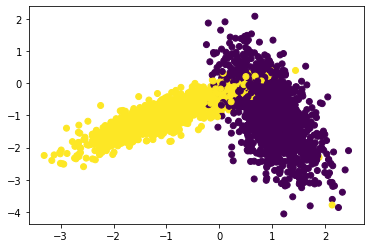

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
#colors = {0:'orange', 1:'blue'}
plt.scatter(X_test[:,0], X_test[:,1],c=y_test)
plt.show()

---

# Implementing Custom GridSearchCV without sklearn


In [20]:
# it will take classifier and set of values for hyper prameter in dict type dict({hyper parmeter: [list of values]})
# we are implementing this only for KNN, hence the hyper parameter should be n_neighbors
from sklearn.metrics import accuracy_score
def randomly_select_60_percent_indices_in_range_from_1_to_len(x_train):
    return random.sample(range(0, len(x_train)), int(0.6*len(x_train)))

def GridSearch(x_train,y_train,classifier, params, folds):
    trainscores = []
    testscores  = []    
    for k in tqdm(params['n_neighbors']):
        trainscores_folds = []
        testscores_folds  = []
        for j in range(0, folds):
            # check this out: https://stackoverflow.com/a/9755548/4084039
            train_indices = randomly_select_60_percent_indices_in_range_from_1_to_len(x_train)
            test_indices  = list(set(list(range(1, len(x_train)))) - set(train_indices))

            # selecting the data points based on the train_indices and test_indices
            X_train = x_train[train_indices]
            Y_train = y_train[train_indices]
            X_test  = x_train[test_indices]
            Y_test  = y_train[test_indices]

            classifier.n_neighbors = k
            classifier.fit(X_train,Y_train)

            Y_predicted = classifier.predict(X_test)
            testscores_folds.append(accuracy_score(Y_test, Y_predicted))

            Y_predicted = classifier.predict(X_train)
            trainscores_folds.append(accuracy_score(Y_train, Y_predicted))
        trainscores.append(np.mean(np.array(trainscores_folds)))
        testscores.append(np.mean(np.array(testscores_folds)))
    return trainscores,testscores

100%|██████████| 11/11 [00:06<00:00,  1.82it/s]


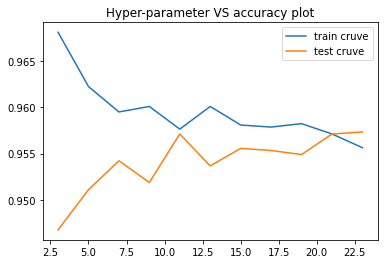

In [21]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")


neigh = KNeighborsClassifier()

params = {'n_neighbors':[3,5,7,9,11,13,15,17,19,21,23]}
folds = 3

trainscores,testscores = GridSearch(X_train, y_train, neigh, params, folds)
 

plt.plot(params['n_neighbors'],trainscores, label='train cruve')
plt.plot(params['n_neighbors'],testscores, label='test cruve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [22]:
# understanding this code line by line is not that importent 
def plot_decision_boundary(X1, X2, y, clf):
        # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

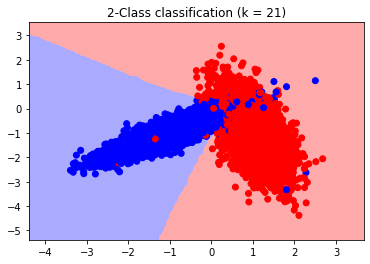

In [23]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 21)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

---

# Implementing RandomSearchCV from scratch (without scikit-learn)

Grid Search can be thought of as an exhaustive search for selecting a model. In Grid Search, the data scientist sets up a grid of hyperparameter values and for each combination, trains a model and scores on the testing data. In this approach, every combination of hyperparameter values is tried which can be very inefficient. For example, searching 20 different parameter values for each of 4 parameters will require 160,000 trials of cross-validation. This equates to 1,600,000 model fits and 1,600,000 predictions if 10-fold cross validation is used. While Scikit Learn offers the GridSearchCV function to simplify the process, it would be an extremely costly execution both in computing power and time.

### An alternative way to perform hyperparameter optimization is to perform random sampling on the grid and perform k-fold cross-validation on some randomly selected cells.

Random Search sets up a grid of hyperparameter values and selects random combinations to train the model and score. This allows you to explicitly control the number of parameter combinations that are attempted. The number of search iterations is set based on time or resources. Scikit Learn offers the RandomizedSearchCV function for this process.

So reducing computational expense using RandomizedSearchCV() is its greatest benefit

For example
- Searching 10 parameters (each range of 1000)
- Require 10,000 trials of CV
- 100,000 model fits with 10-fold CV
- 100,000 predictions with 10-fold CV

`RandomizedSearchCV()` searches a subset of the parameters, and you control the computational "budget" You can decide how long you want it to run for depending on the computational time we have

Scikit-learn provides an optimizer called **`RandomizedSearchCV()`** to perform a random search for the purpose of hyperparameter optimization.

Notice that **`RandomizedSearchCV()`** requires the extra `n_iter` argument, which determines how many random cells must be selected. This determines how many times k-fold cross-validation will be performed. Therefore, by choosing a smaller number, fewer hyperparameter combinations will be considered and the method will take less time to complete. Also, please note that the param_grid argument is changed to param_distributions here. The param_distributions argument can take a dictionary with parameter names as keys, and either list of parameters or distributions as values for each key.

It could be argued that **`RandomizedSearchCV()`** is not as good as **`GridSearchCV()`** since it does not consider all the possible values and combinations of values for hyperparameters, which is reasonable. As a result, one smart way of performing hyperparameter tuning for deep learning models is to start with either **`RandomizedSearchCV()`** on many hyperparameters, or **`GridSearchCV()`** on fewer hyperparameters with larger gaps between them.

By beginning with a randomized search on many hyperparameters, we can determine which hyperparameters have the most influence on a model's performance. It can also help narrow down the range for important hyperparameters. Then, you can complete your hyperparameter tuning by performing **`GridSearchCV()`** on the smaller number of hyperparameters and the smaller ranges for each of them. This is
called the coarse-to-fine approach to hyperparameter tuning. 

The first step is to write the parameters that we want to consider and from these parameters select the best ones.

In [24]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import  tqdm
import random

### Creating a dataset with make_classification()

In [25]:
x, y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant=0, n_clusters_per_class=1, random_state=60)
X_train, X_test, y_train, y_test = train_test_split(x, y, stratify=y, random_state=42)

print('X_train :', X_train)
X_train.shape

X_train : [[ 0.45267141 -1.42381257]
 [ 0.61696406 -0.00418956]
 [-1.80708012 -1.34499648]
 ...
 [ 0.63107723 -0.4743162 ]
 [-0.47320722 -0.6387028 ]
 [ 1.07909424 -1.67541279]]


(7500, 2)

In [26]:
print('y_train : ', y_train)
y_train.shape

y_train :  [0 0 1 ... 0 1 0]


(7500,)

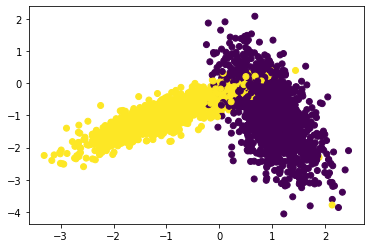

In [27]:
import matplotlib.pyplot as plt
colors = { 0: 'red', 1: 'blue'}
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
plt.show()

## pseudocode for RandomSearchCV (without scikit-learn)

### The Algorithim steps to implement RandomSearchCV


def RandomSearchCV(x_train,y_train,classifier, param_range, folds):
    # x_train: its numpy array of shape, (n,d)
    # y_train: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # folds: an integer, represents number of folds we need to devide the data and test our model
    
    
    #1.generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params" 
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    #2.devide numbers ranging from  0 to len(X_train) into groups= folds
    # ex: folds=3, and len(x_train)=100, we can devide numbers from 0 to 100 into 3 groups 
      group 1: 0-33, group 2:34-66, group 3: 67-100
    #3.for each hyperparameter that we generated in step 1:
        # and using the above groups we have created in step 2 you will do cross-validation as follows
        
        # first we will keep group 1+group 2 i.e. 0-66 as train data and group 3: 67-100 as test data, and find train and
          test accuracies
          
        # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and group 2: 34-66 as test data, and find
          train and test accuracies
          
        # third we will keep group 2+group 3 i.e. 34-100 as train data and group 1: 0-33 as test data, and find train and
          test accuracies
        # based on the 'folds' value we will do the same procedure
        
        # find the mean of train accuracies of above 3 steps and store in a list "train_scores"
        # find the mean of test accuracies of above 3 steps and store in a list "test_scores"
    #4. return both "train_scores" and "test_scores"

#5. call function RandomSearchCV(x_train,y_train,classifier, param_range, folds) and store the returned values into "train_score", and "cv_scores"
#6. plot hyper-parameter vs accuracy plot as shown in reference notebook and choose the best hyperparameter
#7. plot the decision boundaries for the model initialized with the best hyperparameter, as shown in the last cell of reference notebook

</pre>


In [28]:
from sklearn.metrics import accuracy_score


def randomized_search_cv_custom(x_train_total, y_train_total, classifier, param_range, num_of_total_fold):
    # x_train_total: its numpy array of shape, (n,d)
    # y_train_total: its numpy array of shape, (n,) or (n,1)
    # classifier: its typically KNeighborsClassifier()
    # param_range: its a tuple like (a,b) a < b
    # num_of_total_fold: an integer, represents number of num_of_total_fold we need to devide the data and test our model

    # generating hyper-parameter range
    # generate 10 unique values(uniform random distribution) in the given range "param_range" and store them as "params"
    # ex: if param_range = (1, 50), we need to generate 10 random numbers in range 1 to 50
    ten_random_values_for_param_range = sorted(random.sample(range(1, param_range), 10))

    train_scores = []
    test_scores = []

    classifier_params = { 'n_neighbors': ten_random_values_for_param_range }
    # it will take classifier and set of values for hyper prameter in dict type
    # dict({hyper parmeter: [list of values]})
    # as we are implementing this only for KNN, the hyper parameter should be n_neighbors
    # And I will return it from the function at the end so that I can use this same params
    # while plotting the graph as well

    for k in tqdm(classifier_params['n_neighbors']):
        trainscores_folds = []
        testscores_folds = []

        for j in range(0, num_of_total_fold):
            # divide numbers ranging from  0 to len(x_train_fold) into groups = num_of_total_fold
            # basically, splitting the data into k groups (k = len(x_train_fold) / num_of_total_fold)
            # It works by first training the algorithm on the k_1 group of the data and
            # evaluating it on the kth hold-out group as the test set. This is repeated
            # so that each of the k groups is given an opportunity to be held out and used as the test set.
            # ex: num_of_total_fold=3, and len(x_train_total)=100, we can divide numbers from 0 to 100 into 3 groups
            # group 1: 0-33, group 2:34-66, group 3: 67-100
            num_of_elements_in_each_fold = int(len(x_train_total) / num_of_total_fold)

            # for each hyperparameter that we generated in step 1:
            # and using the above groups we have created in step 2 you will do cross-validation as follows

            # first we will keep group 1+group 2 i.e. 0-66 as train data and
            # group 3: 67-100 as test data, and find train and test accuracies
            # second we will keep group 1+group 3 i.e. 0-33, 67-100 as train data and
            # group 2: 34-66 as test data, and find train and test accuracies
            # third we will keep group 2+group 3 i.e. 34-100 as train data and
            # group 1: 0-33 as test data, and find train and test accuracies
            # based on the 'num_of_total_fold' value we will do the same procedure

            # NOW IMPLEMENTATION OF THE CONCEPT OF 'fold' as below
            # For each of this inner loop running for values of j (where j represents num_of_total_fold of 0, 1, 2, 3 ...)
            # each of the test_indices will have the data of a single fold ( which is = num_of_elements_in_each_fold )
            # i.e. the test_indices will be the range starting at
            # num_of_elements_in_each_fold * j and ending at num_of_elements_in_each_fold * (j + 1)
            # And this whole range needs to be converted to list => then apply set() to the list
            # => and then again converted to list
            test_indices = list(set(list(range((num_of_elements_in_each_fold * j), (num_of_elements_in_each_fold*(j+1))))))
            # print('test_indices ', test_indices)

            # And the whole rest of the indices of the dataset will be the train_indices
            train_indices = list(set(list(range(0, len(x_train_total)))) - set(test_indices) )
            # print('train_indices ', train_indices)

            ''' So for a dataset of total 100 rows, one loop of j, will have the following test_indices and train_indices

            test_indices  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]

            train_indices  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]

            And the next loop of j will have as below (for the same dataset of total 100 rows )

            test_indices  [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
            train_indices  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74]
            '''

            # after we have above, now select datapoints based on test_indices and train_indices
            x_train_fold = x_train_total[train_indices]
            y_train_fold = y_train_total[train_indices]
            x_test_fold = x_train_total[test_indices]
            y_test_fold = y_train_total[test_indices]

            # Now based on our classifier assign corresponding parameter values
            # and also fit() and predict()
            classifier.n_neighbors = k
            classifier.fit(x_train_fold, y_train_fold)

            # First predict based on x_test_fold and keep the accuracy score in the testscores_folds
            y_predicted = classifier.predict(x_test_fold)
            testscores_folds.append(accuracy_score(y_test_fold, y_predicted))

            # Now run prediction based on x_train_fold and append the accuracy score in the trainscores_folds
            y_predicted = classifier.predict(x_train_fold)
            trainscores_folds.append(accuracy_score(y_train_fold, y_predicted))

        train_scores.append(np.mean(np.array(trainscores_folds)))
        test_scores.append(np.mean(np.array(testscores_folds)))

    return train_scores, test_scores, classifier_params

In [29]:

from sklearn.neighbors import KNeighborsClassifier
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Our Classifier is KNN, hence assign a variable to it.
neigh = KNeighborsClassifier()
params_range = 50
number_of_total_folds = 3

# Now invoking our custom function randomized_search_cv_custom(x_train,y_train,classifier, param_range, num_of_total_fold) and store the returned values
testscores, trainscores, params = randomized_search_cv_custom(X_train, y_train, neigh, params_range, number_of_total_folds)

print('trainscores are: ', trainscores)
print('testscores are: ', testscores)

100%|██████████| 10/10 [00:06<00:00,  1.63it/s]

trainscores are:  [0.9296000000000001, 0.9548, 0.9545333333333333, 0.9538666666666668, 0.9541333333333334, 0.9538666666666668, 0.9561333333333333, 0.9561333333333333, 0.9556, 0.956]
testscores are:  [1.0, 0.9579333333333334, 0.9575333333333335, 0.9570666666666666, 0.9575999999999999, 0.9573999999999999, 0.9580000000000001, 0.9579333333333334, 0.9579333333333334, 0.9586]


## Plotting hyper-parameter vs accuracy plot

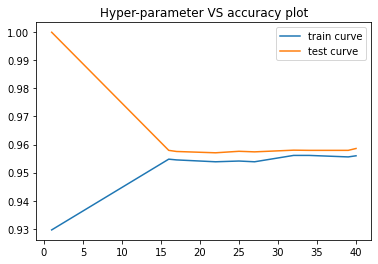

In [30]:
# Now plotting hyper-parameter vs accuracy plot to choose the best hyperparameter
plt.plot(params['n_neighbors'], trainscores, label='train curve')
plt.plot(params['n_neighbors'], testscores, label='test curve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()


In [31]:
def plot_decision_boundary(X1, X2, y, clf):
    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1

    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

## Plotting the decision boundaries for the model initialized with the best hyperparameter

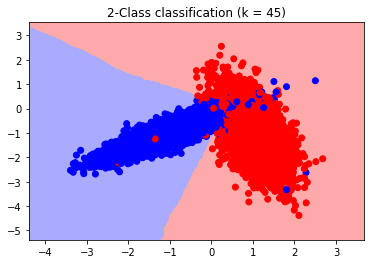

In [32]:
# plotting the decision boundaries for the model initialized with the best hyperparameter (45)
neigh = KNeighborsClassifier(n_neighbors = 45)
neigh.fit(X_train, y_train)
plot_decision_boundary(X_train[:, 0], X_train[:, 1], y_train, neigh)

---

# Implementing Decision Function of SVM RBF Kernel from scratch (without sklearn)

After we train a kernel SVM model, we will be getting support vectors and their corresponsing coefficients $\alpha_{i}$

Check below scikit-learn documentation for better understanding of these attributes: 

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html

<img src='https://i.imgur.com/K11msU4.png' width=500>

Here we will be implementing the *`decision_function()`* of kernel SVM, and the *`decision_function()`* here means that, based on the value return by *`decision_function()`* the model will classify the data point either as positive or negative.

For example, In logistic regression After traning the models with the optimal weights $w$ we get, we will find the value 

### $$\frac{1}{1+\exp(-(wx+b))}$$, 

If this value comes out to be < 0.5 we will mark it as negative class, else its positive class

Another Example In Linear SVM After traning the models with the optimal weights $w$ we get, we will find the value of $sign(wx+b)$, if this value comes out to be -ve we will mark it as negative class, else its positive class.

Similarly in Kernel SVM After traning the models with the coefficients $\alpha_{i}$ we get, we will find the value of 

### $sign(\sum_{i=1}^{n}(y_{i}\alpha_{i}K(x_{i},x_{q})) + intercept)$, here $K(x_{i},x_{q})$

is the RBF kernel. If this value comes out to be -ve we will mark $x_{q}$ as negative class, else its positive class.

RBF kernel is defined as: 

## $K(x_{i},x_{q})$ = $exp(-\gamma ||x_{i} - x_{q}||^2)$

For better understanding [refer here](https://scikit-learn.org/stable/modules/svm.html#svm-mathematical-formulation)


#### Now here's our workflow

> 1. Split the data into $X_{train}$(60), $X_{cv}$(20), $X_{test}$(20)

> 2. Train $SVC(gamma=0.001, C=100.)$ on the ($X_{train}$, $y_{train}$)

> 3. Get the decision boundry values $f_{cv}$ on the $X_{cv}$ data  i.e. ` `$f_{cv}$ ```= decision_function(```$X_{cv}$```)```  we are going to implement this decision_function()

In [33]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import numpy as np
from sklearn.svm import SVC

In [34]:
X, y = make_classification(n_samples=5000, n_features=5, n_redundant=2,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)

### Pseudo code

clf = SVC(gamma=0.001, C=100.)
clf.fit(Xtrain, ytrain)

![Imgur](https://imgur.com/S1Ek49k.png)
    
fcv = decision_function(Xcv, ...)  <i># based on your requirement you can pass any other parameters </i>

Note; Make sure the values you get as fcv, should be equal to outputs of clf.decision_function(Xcv)

---


### A note on what is dual_coef in SVC

In your `clf`, 

`coef_` are the weights assigned to the features; (Note it only works for linear SVM)

 `support_vectors_` and `support_` are the support vectors and the corresponding index;

`dual_coef_` is the coefficients of the support vector in the decision function; and 

`intercept_` is the bias in decision function.

In linear SVM, $w^Tx+b=0$ is the decision boundary, and $w$ is the coefficients of the support vectors, $b$ is the bias, all defined above.

#### Some more on dual_coef if SVC from [here](https://stackoverflow.com/questions/22816646/the-dimension-of-dual-coef-in-sklearn-svc)


The dual coefficients of a sklearn.svm.SVC in the multiclass setting are tricky to interpret. There is an explanation in the [scikit-learn documentation](http://scikit-learn.org/stable/modules/svm.html#multi-class-classification). The sklearn.svm.SVC uses [libsvm](http://www.csie.ntu.edu.tw/~cjlin/libsvm/) for the calculations and adopts the same data structure for the dual coefficients. Another explanation of the organization of these coefficients is in the [FAQ](http://www.csie.ntu.edu.tw/~cjlin/libsvm/faq.html#f402). In the case of the coefficients you find in the fitted SVC classifier, interpretation goes as follows:

The support vectors identified by the SVC each belong to a certain class. In the dual coefficients, they are ordered according to the class they belong to.
Given a fitted SVC estimator, e.g.

    from sklearn.svm import SVC
    svc = SVC()
    svc.fit(X, y)

you will find

    svc.classes_   # represents the unique classes
    svc.n_support_ # represents the number of support vectors per class


#### From official guide - dual_coef

dual_coef_ => ndarray of shape (n_classes -1, n_SV)

Dual coefficients of the support vector in the decision function (see Mathematical formulation), multiplied by their targets. For multiclass, coefficient for all 1-vs-1 classifiers. 

### RBF Kernel Notes


||x - x'||² is the squared Euclidean distance between two feature vectors (2 points).
Gamma is a scalar that defines how much influence a single training example (point) has.


### C Parameter

It controls the trade off between smooth decision boundary and classifying training points correctly. A large value of c means you will get more training points correctly. Large value of c means you will get more intricate decision curves trying to fit in all the points.


### Gamma Parameter

It defines how far the influence of a single training example reaches. If it has a low value it means that every point has a far reach and conversely high value of gamma means that every point has close reach.

If gamma has a very high value, then the decision boundary is just going to be dependent upon the points that are very close to the line which effectively results in ignoring some of the points that are very far from the decision boundary. This is because the closer points get more weight and it results in a wiggly curve as shown in previous graph.On the other hand, if the gamma value is low even the far away points get considerable weight and we get a more linear curve.


---


### Now the code for this


In [35]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
import numpy as np
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
import math
import matplotlib.pyplot as plt


X, y = make_classification(n_samples=5000, n_features=5, n_redundant=2,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)

x, x_test, y, y_test = train_test_split(X, y, test_size=0.2, train_size=0.8)

X_train, x_cv, y_train, y_cv = train_test_split(x, y, test_size = 0.25, train_size = 0.75)

clf = SVC(gamma=0.001, C=100.)

clf.fit(X_train, y_train)

dual_coeff = clf.dual_coef_[0]

support_vectors = clf.support_vectors_

print('dual_coeff.shape ', dual_coeff.shape)
print('support_vectors ', support_vectors.shape)

intercept = clf.intercept_

print('intercept ', intercept)

dual_coeff.shape  (541,)
support_vectors  (541, 5)
intercept  [-0.74574216]


In [36]:
def decision_function(Xcv):
  sample_output_rbf = 0
  y_predicted = []
  gamma = clf._gamma
  
  for x_q in Xcv:
    kernel_sum = 0
    for i in range(len(support_vectors)):
      squared_distance = (np.linalg.norm(support_vectors[i] - x_q)**2)
      rbf_k = np.exp(-gamma * (squared_distance))
      kernel_sum += dual_coeff[i]*rbf_k    
    
    sample_output_rbf = kernel_sum + intercept
    y_predicted.append(sample_output_rbf[0])
    
  return np.array(y_predicted)    
      

In [37]:
svm_decision_inbuilt_result_x_cv = clf.decision_function(x_cv)
# svm_decision_inbuilt_result_x_cv = clf.decision_function(x_test)
# svm_decision_inbuilt_result_x_test = clf.decision_function(x_test)
# print('x_test.shape x', svm_decision_inbuilt_result_x_test.shape)

print('inbuilt_decision_function: first 5 elements ', svm_decision_inbuilt_result_x_cv[:5] )

custom_decision_function_result_x_cv = decision_function(x_cv)
print('custom_decision_function_result: first 5 elements ', custom_decision_function_result_x_cv[:5])

inbuilt_decision_function: first 5 elements  [ 0.75552888  1.44273623 -3.62324862 -1.5869519   1.20475914]
custom_decision_function_result: first 5 elements  [ 0.75552888  1.44273623 -3.62324862 -1.5869519   1.20475914]


---

# Implementing Platt Scaling to find P(Y==1|X) from scratch (without sklearn)


Here we will be doing the following


- Applying SGD algorithm with ($f_{cv}$, $y_{cv}$) and find the weight $W$ intercept $b$ ```Note: here our data is of one dimensional so we will have a one dimensional weight vector i.e W.shape (1,)``` 

- Note1: We have to change the values of $y_{cv}$ as mentioned in the above image. we will calculate y+, y- based on data points in train data

- Note2: the Sklearn's SGD algorithm doesn't support the real valued outputs. We have to use below logrithmic transformation

<img src='https://i.imgur.com/zKYE9Oc.png'>

## The MOST IMPORTANT Point is - if Y[i] is 1, it will be replaced with y+ value else it will replaced with y- value

- Finally, for a given data point from $X_{test}$, $P(Y=1|X) = \frac{1}{1+exp(-(W*f_{test}+ b))}$ where ` `$f_{test}$ ```= decision_function(```$X_{test}$```)```, W and b will be learned as metioned in the above step

Check this paper for reference on [Platt Scaling and Isotonic Regression.](https://drive.google.com/open?id=133odBinMOIVb_rh_GQxxsyMRyW-Zts7a)


<img src='https://i.imgur.com/CAMnVnh.png'>




In [38]:
# Randomly initializing weights (w) and intercept values (b)
# dim — size of the w vector we want (or number of features or parameters in this case)
def initialize_weights(dim):
    ''' In this function, we will initialize our weights and bias
    w — weights, a numpy array of size
    b — bias, a scalar
    '''
    #initialize the weights to zeros array of (1,dim) dimensions
    #you use zeros_like function to initialize zero, check this link https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros_like.html
    #initialize bias to zero
    w = np.zeros_like(dim)
    # Above will initialize all w with 0.
    b = 0
    return w,b
  
def sigmoid(z):
    return 1.0/(1 + np.exp(-z)) 



def logloss(y_true, y_pred):
    
    len_y_true = len(y_true)
    
    number_of_plus = np.count_nonzero(y_true == 1)
    number_of_minus = np.count_nonzero(y_true == 0)
    
    # Plat scaling
    # we will calculate y+, y- based on data points in train data
    y_plus = (number_of_plus+1)/(number_of_minus+2)
    y_minus = 1/(number_of_minus+2)
    
    sum_of_loss = 0
    
    for i in range(0, len_y_true):
      if (y_true[i] == 1):
        sum_of_loss += ((y_plus * np.log10(y_pred[i])) + ((1- y_plus) * np.log10(1-y_pred[i])))
      else:
        sum_of_loss += ((y_minus * np.log10(y_pred[i])) + ((1 - y_minus) * np.log10(1-y_pred[i])))
        
    loss = (-1/len_y_true) * sum_of_loss  
    return loss
    
    
  
def gradient_dw(x,y,w,b,alpha,N):
    '''In this function, we will compute the gardient w.r.to w '''
    z = np.dot(w, x) + b
    dw = x*(y - sigmoid(z)) - ((alpha)*(1/N) * w)
    return dw
  
  
def gradient_db(x,y,w,b):
    z = np.dot(w, x) + b
    db = y - sigmoid(z)

    return db

In [39]:
def train(X_train, y_train, X_test, y_test, epochs, alpha, eta0, tol=1e-3):
    """ In this function, we will implement logistic regression"""
    # Here eta0 is learning rate
    # implement the code as follows
    # initialize the weights (call the initialize_weights(X_train[0]) function)
    w, b = initialize_weights(X_train[0])
    # for every epoch
    train_loss = []
    test_loss = []
    N = len(X_train)

    loss_threshold = 0.0001

    for epoch in range(epochs):
        # for every data point(X_train,y_train)
        for row in range(N - 1):
            # compute gradient w.r.to w (call the gradient_dw() function)
            delta_weights = gradient_dw(
                X_train[row], y_train[row], w, b, alpha, len(X_train)
            )

            # compute gradient w.r.to b (call the gradient_db() function)
            delta_bias = gradient_db(X_train[row], y_train[row], w, b)

            # update w, b
            w = w + eta0 * delta_weights
            b = b + eta0 * delta_bias

        # predict the output of x_train[for all data points in X_train] using w,b
        # y_prediction_train is a numpy array (vector) containing all predictions (0/1) for the examples in X
        y_prediction_train = [  
        sigmoid(np.dot(w, x_row) + b) for x_row in X_train
        ]

        # compute the loss between predicted and actual values (call the loss function)
        # store all the train loss values in a list
        train_loss.append(logloss(y_train, y_prediction_train))

        # predict the output of x_test[for all data points in X_test] using w,b
        y_prediction_test = [
            sigmoid(np.dot(w, x_row) + b) for x_row in X_test
        ]

        print(
            f"For EPOCH No : {epoch} Train Loss is : {logloss(y_train, y_prediction_train)} and Test Loss is : {logloss(y_test, y_prediction_test)}"
        )

        # compute the loss between predicted and actual values (call the loss function)
        test_loss.append(logloss(y_test, y_prediction_test))

      

    return w, b, train_loss, test_loss

In [40]:
alpha=0.0001
eta0=0.0001
# N=len(X_train)
epochs=50

w, b, cv_log_loss, test_loss = train(custom_decision_function_result_x_cv, y_cv, x_test, y_test, epochs, alpha, eta0)
print('w_coef ', w)
print('intercept b ', b)

For EPOCH No : 0 Train Loss is : 0.26885803159945876 and Test Loss is : [0.2986248  0.29826254 0.30113306 0.30187636 0.2893107 ]
For EPOCH No : 1 Train Loss is : 0.2454454472700635 and Test Loss is : [0.29741689 0.2969077  0.30141    0.30285896 0.27994303]
For EPOCH No : 2 Train Loss is : 0.22823388015858556 and Test Loss is : [0.29703551 0.29651975 0.30180925 0.30392175 0.27236665]
For EPOCH No : 3 Train Loss is : 0.21540075141706289 and Test Loss is : [0.29722274 0.29679005 0.30229369 0.30502812 0.2661562 ]
For EPOCH No : 4 Train Loss is : 0.20568934313177334 and Test Loss is : [0.29780251 0.29750938 0.30283712 0.30615459 0.26099714]
For EPOCH No : 5 Train Loss is : 0.19823840589269984 and Test Loss is : [0.29865471 0.29853623 0.30342108 0.30728618 0.25665806]
For EPOCH No : 6 Train Loss is : 0.19245320193381843 and Test Loss is : [0.2996967  0.29977411 0.30403252 0.30841338 0.25296776]
For EPOCH No : 7 Train Loss is : 0.18791718145211922 and Test Loss is : [0.3008709  0.30115645 0.3

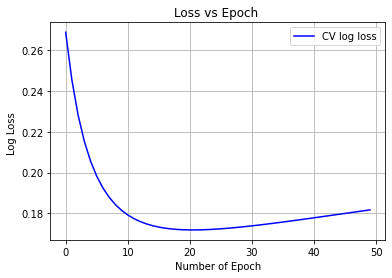

In [41]:
x = np.array([i for i in range(0, 50)])

cv_log_loss_arr = np.array(cv_log_loss)

plt.plot(x, cv_log_loss_arr, "-b", label = 'CV log loss')

plt.legend(loc="upper right")
plt.grid()

plt.xlabel('Number of Epoch')
plt.ylabel('Log Loss ')

plt.title('Loss vs Epoch ')
plt.show()

---

### Implementing the custom decision funtion on x_test

In [42]:
custom_decision_function_result_x_test = decision_function(x_test)
print('Shape of custom_decision_function_result_x_test ', custom_decision_function_result_x_test.shape)

prob_arr_x_test_custom_decision_func = []

for i in custom_decision_function_result_x_test:
  i_proba = 1/(1 + np.exp((-w * i) - b) )
  prob_arr_x_test_custom_decision_func.append(i_proba)
  
  
print('First 5 elements prob_arr_x_test_custom_decision_func ', prob_arr_x_test_custom_decision_func[:5])



Shape of custom_decision_function_result_x_test  (1000,)
First 5 elements prob_arr_x_test_custom_decision_func  [0.7841820635095523, 0.026245180568788305, 0.0237915547528282, 0.9852550688799704, 0.06673774577966177]


---

# Implementing SGD Classifier with Logloss and L2 regularization using SGD from scratch (WITHOUT using sklearn)

## Problem with Regular Gradient Descent


In machine learning, we are familiar with the concept of error and we are generally concerned with minimizing said error by modelling error as a function and defining the optimal model that has the lowest error

Recall in linear regression, we were conerned with minimising the sum of squared residuals. In Calculus, to find the optimal point of a function, we must utilize the **derivative**.

In vector (multi-dimensional) calculus, we generalize the concept of the derivative as the gradient.

The gradient is the derivative of a single function of all of its variables. We use the gradient in roder to create a **directional derivative**. The directional derivative gives us both a direction and magnitute of "how steep" the function is at that point and facing that direction. Our goal is follow the directional derivatives to find the minimum (or maximum) value of a function.

<b>Gradient descent</b>, also known as <b>steepest descent</b>, is an optimization algorithm for finding the local minimum of a function. To find a local minimum, the function "steps" in the  direction of the negative of the gradient. <b>Gradient ascent</b> is the same as gradient descent, except that it steps in the direction of the positive of the gradient and therefore finds local maximums instead of minimums. The algorithm of gradient descent can be outlined as follows:

![Imgur](https://imgur.com/WW3W5Hb.png)


As a simple example, let's find a local minimum for the function $f(x) = x^3-2x^2+2$

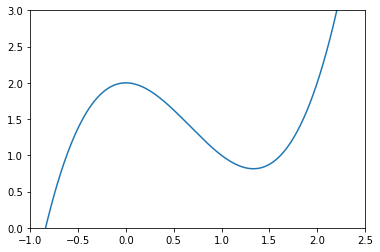

In [43]:
# define a function f
f = lambda x: x**3-2*x**2+2

x = np.linspace(-1,2.5,1000)
plt.plot(x,f(x))
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.show()

We can see from plot above that our local minimum is gonna be near around 1.4 or 1.5 (on the x-axis), but let's pretend that we don't know that, so we set our starting point (arbitrarily, in this case) at $x_0 = 2$

In [44]:
x_old = 0
x_new = 2 # The algorithm starts at x=2
learning_rate = 0.1 # step size
precision = 0.0001  # stopping criterions

x_list, y_list = [x_new], [f(x_new)]

# returns the value of the derivative of our function
def f_prime(x):
    return 3*x**2-4*x
 
while abs(x_new - x_old) > precision:
    x_old = x_new
    gradient = f_prime(x_old) # f'(2) = 4
    x_new = x_old + (learning_rate * -gradient) # x_new = 2 + (.1 * -4) == 1.6
    x_list.append(x_new)
    y_list.append(f(x_new))
print("Local minimum occurs at:", x_new)
print("Number of steps:", len(x_list))

Local minimum occurs at: 1.3334253508453249
Number of steps: 17


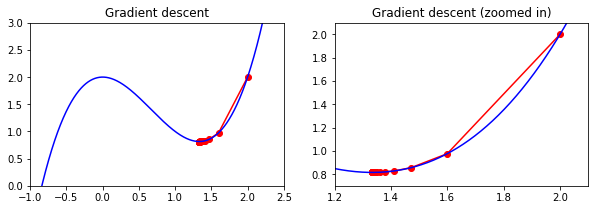

In [45]:
plt.figure(figsize=[10,3])
plt.subplot(1,2,1)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([-1,2.5])
plt.ylim([0,3])
plt.title("Gradient descent")
plt.subplot(1,2,2)
plt.scatter(x_list,y_list,c="r")
plt.plot(x_list,y_list,c="r")
plt.plot(x,f(x), c="b")
plt.xlim([1.2,2.1])
plt.ylim([.7,2.1])
plt.title("Gradient descent (zoomed in)")
plt.show()

Why do we follow the negative gradient (negative derivatives?) Because to calculate the directional derivative we must do:

Directional Derivative of function f($D_u(f)$) = $\nabla f.u$ where u is the unit vector in the direction we care about.

|x| indicates **magnitute** which is the length of the vector. The magnitute of the directional derivative gives us the rate of change of movement in that direction.

We also know that $\nabla f.u = |\nabla(f)|$*   $|u|$  *  $cos(\theta)$ where $\theta$ is the angle between the two vectors.

because $u$ is a unit vector, it has length one, so we are left with

$D_u(f) = |\nabla(f)|cos(\theta)$

The maximum value of this directional derivative ccours when the $cos(\theta) = 1$ when $\theta=0$ therefore when the vector u is the same direction as $\nabla f$

The maximum value of $D_u(f)$ (and hence then the maximum rate of change of the function  ) is therefore given by $|D_u(f)|$  and will occur in the direction given by $\nabla f(x)$.

---

So overall, our goal is to find the equation of the straight line $h_\theta(x) = \theta_0 + \theta_1 x$ that best fits our data points. The function that we are trying to minimize in this case is the sum of squared residuals:

$J(\theta_0,\theta_1) = \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)^2$

In this case, our gradient will be defined in two dimensions:

$\frac{\partial}{\partial \theta_0} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)$

$\frac{\partial}{\partial \theta_1} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m ((h_\theta(x_i)-y_i) \cdot x_i)$

---

## Implementing SGD Classifier with Logloss and L2 regularization using SGD from scratch

Notice that in the method above (for regular Gradient Descent) we need to calculate the gradient in every step of our algorithm. In our example , this is not a big deal since there are only a hundred data points. But imagine that we had 2 million data points. If this were the case, it would certainly make the method above far less efficient.

In machine learning, the algorithm above is often called <b>batch gradient descent</b> to contrast it with <b>mini-batch gradient descent</b> (which we will not go into here) and <b>stochastic gradient descent</b>.


The implementation of the regular/classic gradient descent method consists of initially evaluating both the
function and its gradient, starting from a configuration chosen randomly in the space of
dimensions.

From here, we try to move in the direction indicated by the gradient. This establishes a
direction of descent in which the function tends to a minimum and examines whether the
function actually takes on a value lower than that calculated in the previous configuration.
If so, the procedure continues iteratively, recalculating the new gradient. This can be
totally different from the previous one. After this, it starts again in search of a new
minimum.


This iterative procedure requires that, at each step, the entire system status is updated. This
means that all the parameters of the system must be recalculated. From a computational
point of view, this equates to an extremely expensive operating cost and greatly slows
down the estimation procedure. With respect to the standard gradient descent method, in
which the weights are updated after calculating the gradient for the entire dataset, in the
stochastic method, the system parameters are updated after a certain number of examples.
These are chosen randomly in order to speed up the process and to try and avoid any local
minimum situations.


Consider a dataset that contains n observations of a phenomenon. Here, let f be an
objective function that we want to minimize with respect to a series of parameters x. Here,
we can write the following equation:

![Imgur](https://imgur.com/s4yhbwP.png)


From the analysis of the previous equation, we can deduce that the evaluation of the
objective function f requires n evaluations of the function f, one for each value contained
in the dataset.

In the classic gradient descent method, at each step, the function gradient is calculated in
correspondence with all the values of the dataset through the following equation:

![Imgur](https://imgur.com/z0jVNbX.png)


In some cases, the evaluation of the sum present in the previous equation can be
particularly expensive, such as when the dataset is particularly large and there is no
elementary expression for the objective function. The stochastic descent of the gradient
solves this problem by introducing an approximation of the gradient function. At each
step, instead of the sum of the gradients being evaluated in correspondence to the data
contained in the dataset, the evaluation of the gradient is used only in a random subset of
the dataset.

## Stochastic gradient descent vs  classic gradient descent method


So, the previous equation replaces the following:


![Imgur](https://imgur.com/VRCiVwR.png)

In this equation, $∇f_i(x_n)$ is the gradient of one of the observations in the dataset, chosen randomly.


The pros of this technique are as follows:

• Based only on a part of the observations, the algorithm allows a wider exploration
of the parametric space, with the greater possibility of finding new and potentially
better points of the minimum.

• Taking a step of the algorithm is computationally much faster, which ensures faster
convergence toward the minimum point.

• The parameter estimates can also be calculated by loading only a part of the dataset
into memory at a time, allowing this method to be applied to large datasets.


---

So, as we said above, in batch gradient descent, we must look at every example in the entire training set on every step (in cases where a training set is used for gradient descent). This can be quite slow if the training set is sufficiently large. In <b>stochastic gradient descent</b>, we update our values after looking at <i>each</i> item in the training set, so that we can start making progress right away. Recall the linear regression example above. In that example, we calculated the gradient for each of the two theta values as follows:

$\frac{\partial}{\partial \theta_0} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m (h_\theta(x_i)-y_i)$

$\frac{\partial}{\partial \theta_1} J(\theta_0,\theta_1) = 2  \sum\limits_{i=1}^m ((h_\theta(x_i)-y_i) \cdot x_i)$

Where $h_\theta(x) = \theta_0 + \theta_1 x$

Then we followed this algorithm (where $\alpha$ was a non-adapting stepsize):

&nbsp;&nbsp;&nbsp; 1: &nbsp; Choose initial guess $x_0$ 
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> 
&nbsp;&nbsp;&nbsp;    3:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $s_k$ = -$\nabla f(x_k)$ 
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $x_{k+1} = x_k + \alpha s_k$ 
&nbsp;&nbsp;&nbsp;    5: &nbsp;  <b>end for</b>

When the sample data had a hundred data points as in the example above, calculating the gradient was not very costly. But for very large data sets, this would not be the case. So instead, we consider a stochastic gradient descent algorithm for simple linear regression such as the following, where m is the size of the data set:

&nbsp;&nbsp;&nbsp; 1: &nbsp; Randomly shuffle the data set 
&nbsp;&nbsp;&nbsp;    2: &nbsp; <b>for</b> k = 0, 1, 2, ... <b>do</b> 
&nbsp;&nbsp;&nbsp;    3: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>for</b> i = 1 to m <b>do</b> 
&nbsp;&nbsp;&nbsp;    4:   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\begin{bmatrix}
 \theta_{1} \\ 
 \theta_2 \\ 
 \end{bmatrix}=\begin{bmatrix}
 \theta_1 \\ 
 \theta_2 \\ 
 \end{bmatrix}-\alpha\begin{bmatrix}
 2(h_\theta(x_i)-y_i) \\ 
 2x_i(h_\theta(x_i)-y_i) \\ 
 \end{bmatrix}$ 
&nbsp;&nbsp;&nbsp;    5: &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <b>end for</b>  
&nbsp;&nbsp;&nbsp;    6: &nbsp;  <b>end for</b>

Typically, with stochastic gradient descent, you will run through the entire data set 1 to 10 times (see value for k in line 2 of the pseudocode above), depending on how fast the data is converging and how large the data set is.

With batch gradient descent, we must go through the entire data set before we make any progress. With this algorithm though, we can make progress right away and continue to make progress as we go through the data set. Therefore, stochastic gradient descent is often preferred when dealing with large data sets.

Unlike gradient descent, stochastic gradient descent will tend to oscillate <i>near</i> a minimum value rather than continuously getting closer. It may never actually converge to the minimum though. One way around this is to slowly decrease the step size $\alpha$ as the algorithm runs. However, this is less common than using a fixed $\alpha$.

---

## Now the implementation of SGD

In below there are some functions that start with the word "grader" ex: grader_weights(), grader_sigmoid(), grader_logloss() etc. This is for checking our intermediate functions, and every Grader function has to return True.

In [46]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt

### Creating custom dataset

In [47]:
# please don't change random_state
X, y = make_classification(n_samples=50000, n_features=15, n_informative=10, n_redundant=5,
                           n_classes=2, weights=[0.7], class_sep=0.7, random_state=15)
# make_classification is used to create custom dataset 
# - for more details - https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

In [48]:
X.shape, y.shape

((50000, 15), (50000,))

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=15)

In [50]:
# Standardizing the data.
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


''' 
From - https://datascience.stackexchange.com/a/65170/101199

sklearn generally doesn't apply scaling inside of any of its models, instead relying on the user to do that.  This seems like the right way to do it, since you might want to try different scaling techniques depending on your data.

From the [User Guide][1]:
> Stochastic Gradient Descent is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1...  

  [1]: https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use
'''

" \nFrom - https://datascience.stackexchange.com/a/65170/101199\n\nsklearn generally doesn't apply scaling inside of any of its models, instead relying on the user to do that.  This seems like the right way to do it, since you might want to try different scaling techniques depending on your data.\n\nFrom the [User Guide][1]:\n> Stochastic Gradient Descent is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1...  \n\n  [1]: https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use\n"

In [51]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((37500, 15), (37500,), (12500, 15), (12500,))

---

# SGDClassifier from scikit-learn

In [52]:
# alpha : float
# Constant that multiplies the regularization term. 

# eta0 : double
# The initial learning rate for the ‘constant’, ‘invscaling’ or ‘adaptive’ schedules.

clf = linear_model.SGDClassifier(eta0=0.0001, alpha=0.0001, loss='log', random_state=15, penalty='l2', tol=1e-3, verbose=2, learning_rate='constant')
clf
# Please check this documentation (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) 

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
              loss='log', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l2', power_t=0.5, random_state=15, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=2, warm_start=False)

In [53]:
# fitting our model
clf.fit(X=X_train, y=y_train)

-- Epoch 1
Norm: 0.70, NNZs: 15, Bias: -0.501317, T: 37500, Avg. loss: 0.552526
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 1.04, NNZs: 15, Bias: -0.752393, T: 75000, Avg. loss: 0.448021
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 1.26, NNZs: 15, Bias: -0.902742, T: 112500, Avg. loss: 0.415724
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 1.43, NNZs: 15, Bias: -1.003816, T: 150000, Avg. loss: 0.400895
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 1.55, NNZs: 15, Bias: -1.076296, T: 187500, Avg. loss: 0.392879
Total training time: 0.03 seconds.
-- Epoch 6
Norm: 1.65, NNZs: 15, Bias: -1.131077, T: 225000, Avg. loss: 0.388094
Total training time: 0.03 seconds.
-- Epoch 7
Norm: 1.73, NNZs: 15, Bias: -1.171791, T: 262500, Avg. loss: 0.385077
Total training time: 0.04 seconds.
-- Epoch 8
Norm: 1.80, NNZs: 15, Bias: -1.203840, T: 300000, Avg. loss: 0.383074
Total training time: 0.04 seconds.
-- Epoch 9
Norm: 1.86, NNZs: 15, Bias: -1.229563, T: 337500, Avg. loss: 0.

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0001,
              fit_intercept=True, l1_ratio=0.15, learning_rate='constant',
              loss='log', max_iter=1000, n_iter_no_change=5, n_jobs=None,
              penalty='l2', power_t=0.5, random_state=15, shuffle=True,
              tol=0.001, validation_fraction=0.1, verbose=2, warm_start=False)

In [54]:
clf.coef_, clf.coef_.shape, clf.intercept_
#clf.coef_ will return the weights
#clf.coef_.shape will return the shape of weights
#clf.intercept_ will return the intercept term

(array([[-0.89007184,  0.63162363, -0.07594145,  0.63107107, -0.38434375,
          0.93235243, -0.89573521, -0.07340522,  0.40591417,  0.4199991 ,
          0.24722143,  0.05046199, -0.08877987,  0.54081652,  0.06643888]]),
 (1, 15),
 array([-1.30580538]))

## Pseudocode for implementing Logistic Regression with L2 regularization Using SGD: without using sklearn

After each function, we will check the output of the function with a grader function.

* Initialize the weight_vector and intercept term to zeros (Write your code in def initialize_weights())

* Create a loss function (Write your code in def logloss()) 

 $log loss = -1*\frac{1}{n}\Sigma_{for each Yt,Y_{pred}}(Ytlog10(Y_{pred})+(1-Yt)log10(1-Y_{pred}))$
- for each epoch:

    - for each batch of data points in train: (keep batch size=1)

        - calculate the gradient of loss function w.r.t each weight in weight vector (write your code in def gradient_dw())

        $dw^{(t)} = x_n(y_n − σ((w^{(t)})^{T} x_n+b^{t}))- \frac{λ}{N}w^{(t)})$

        - Calculate the gradient of the intercept (write your code in def gradient_db())

           $ db^{(t)} = y_n- σ((w^{(t)})^{T} x_n+b^{t}))$

        - Update weights and intercept
        $w^{(t+1)}← w^{(t)}+α(dw^{(t)})

        $b^{(t+1)}←b^{(t)}+α(db^{(t)}) $
    - calculate the log loss for train and test with the updated weights 
    - And if you wish, you can compare the previous loss and the current loss, if it is not updating, then
        you can stop the training
    - append this loss in the list ( this will be used to see how loss is changing for each epoch after the training is over )

---

### On  the point of - if the loss is not updating then stop the process

Here I am considering test loss because test set are not seen by your system (model), if you monitor train loss you would most probably be overfitting (because your model has already seen the data and can just remember the data points (so your loss will be really low for train but high will be for test)), you guide your model via test set (assuming test set distribution would reflect real world data).

And also don't stop when "previous loss and the current loss are same" have a "patient" value, meaning you wait for few epochs and see if current loss is smaller than previous loss, lets say for 5 epochs, the reason we do this is gradient could be noisy sometimes due to multiple of factor (smaller batch size, big learning rate and so on), so you need to give some patient before you terminate the learning process.



Initialize weights

In [55]:
# Randomly initializing weights (w) and intercept values (b)
# dim — size of the w vector we want (or number of features or parameters in this case)
def initialize_weights(dim):
    ''' In this function, we will initialize our weights and bias
    w — weights, a numpy array of size
    b — bias, a scalar
    '''
    #initialize the weights to zeros array of (1,dim) dimensions
    #you use zeros_like function to initialize zero, check this link https://docs.scipy.org/doc/numpy/reference/generated/numpy.zeros_like.html
    #initialize bias to zero
    w = np.zeros_like(dim)
    # Above will initialize all w with 0.
    b = 0
    return w,b

Grader function - 1 

In [56]:
dim=X_train[0] 
w,b = initialize_weights(dim)
def grader_weights(w,b):
  assert((len(w)==len(dim)) and b==0 and np.sum(w)==0.0)
  return True
grader_weights(w,b)

True

Compute sigmoid 

$sigmoid(z)= 1/(1+exp(-z))$

In [57]:
def sigmoid(z):
    return 1.0/(1 + np.exp(-z))

In [58]:
def grader_sigmoid(z):
  val=sigmoid(z)
  assert(val==0.8807970779778823)
  return True
grader_sigmoid(2)

True

 Compute loss 

#### $$ log loss = -1 * \frac{1}{n}\Sigma_{for each Y^t, Y_{pred}}(Y^t log10(Y_{pred}) + (1-Y^t) log10(1-Y_{pred})) $$

In [59]:
def logloss(y_true,y_pred):
    sum_of_loss = 0
    for i in range(len(y_true)):
        sum_of_loss += ((y_true[i] * np.log10(y_pred[i])) + ((1-y_true[i]) * np.log10(1-y_pred[i])))

    loss = -1*(1/len(y_true))*sum_of_loss

    return loss

Grader function - 3 

In [60]:
def grader_logloss(true,pred):
  loss=logloss(true,pred)
  assert(loss==0.07644900402910389)
  return True
true=[1,1,0,1,0]
pred=[0.9,0.8,0.1,0.8,0.2]
grader_logloss(true,pred)

True

Compute gradient w.r.to  'w' 

$dw^{(t)} = x_n(y_n − σ((w^{(t)})^{T} x_n+b^{t}))- \frac{λ}{N}w^{(t)}$ 

In [61]:
def gradient_dw(x,y,w,b,alpha,N):
    '''In this function, we will compute the gardient w.r.to w '''
    z = np.dot(w, x) + b
    dw = x*(y - sigmoid(z)) - ((alpha)*(1/N) * w)
    return dw


## Special note on above gradient_dw() function

### How am I multiplying np.dot(w, x) in below function given w is 1-d array with 15 elements i.e. 15 columns and X is a 2-D array with 50,000 rows and 15 columns

```py
def gradient_dw(x,y,w,b,alpha,N):
    '''In this function, we will compute the gardient w.r.to w '''
    z = np.dot(w, x) + b
    dw = x*(y - sigmoid(z)) - ((alpha)*(1/N) * w)
    return dw

```

If w = (1, 15) and X = (100, 15), you can NOT do `w.dot(x)` because

#### Columns of w should match rows of x

When we do multiplication:

The number of columns of the 1st matrix must equal the number of rows of the 2nd matrix.
And the result will have the same number of rows as the 1st matrix, and the same number of columns as the 2nd matrix.

#### To multiply an m×n matrix by an n×p matrix, the n's must be the same, and the result is an m×p matrix.

### $$m*n  \quad Multiply \quad  n*p => m*p \quad Matrix$$

Thats why we should take transpose of w which would make matrix multiplication possible like w.T = (15, 1) now if you take `w.dot(x)` it will return you 1X100 shaped vector. Notice after transpose of W how rows of W and columns of X are matching, and weights are represented as rows rather than columns.


#### But the question is in my above `gradient_dw()` how come I am NOT doing this above transpose

#### [Does np.dot automatically transpose vectors?](https://stackoverflow.com/questions/54160155/does-np-dot-automatically-transpose-vectors)

 It seems that when one of your matrices is one dimensional, then numpy will figure out automatically what you are trying to do.


[The documentation][1] for the dot function has a more specific explanation of the logic applied:

* If both a and b are 1-D arrays, it is inner product of vectors (without complex conjugation).

* If both a and b are 2-D arrays, it is matrix multiplication, but using matmul or a @ b is preferred.

* If either a or b is 0-D (scalar), it is equivalent to multiply and using numpy.multiply(a, b) or a * b is preferred.

* If a is an N-D array and b is a 1-D array, it is a sum product over the last axis of a and b. (THIS IS WHAT IS BEING APPLIED HERE IN THE CASE OF OUR gradient_dw() function)

* If a is an N-D array and b is an M-D array (where M>=2), it is a sum product over the last axis of a and the second-to-last axis of b:


  [1]: https://numpy.org/doc/stable/reference/generated/numpy.dot.html?highlight=dot#numpy.dot

Grader function - 4 

In [62]:
def grader_dw(x,y,w,b,alpha,N):
  grad_dw=gradient_dw(x,y,w,b,alpha,N)
  assert(np.sum(grad_dw)==2.613689585)
  return True
grad_x=np.array([-2.07864835,  3.31604252, -0.79104357, -3.87045546, -1.14783286,
       -2.81434437, -0.86771071, -0.04073287,  0.84827878,  1.99451725,
        3.67152472,  0.01451875,  2.01062888,  0.07373904, -5.54586092])
grad_y=0
grad_w,grad_b=initialize_weights(grad_x)
alpha=0.0001
N=len(X_train)
grader_dw(grad_x,grad_y,grad_w,grad_b,alpha,N)

True

Compute gradient w.r.to 'b' 

$ db^{(t)} = y_n- σ((w^{(t)})^{T} x_n+b^{t})$

In [63]:
def gradient_db(x,y,w,b):
    z = np.dot(w, x) + b
    db = y - sigmoid(z)

    return db

Grader function - 5 

In [64]:
def grader_db(x,y,w,b):
  grad_db=gradient_db(x,y,w,b)
  assert(grad_db==-0.5)
  return True
grad_x=np.array([-2.07864835,  3.31604252, -0.79104357, -3.87045546, -1.14783286,
       -2.81434437, -0.86771071, -0.04073287,  0.84827878,  1.99451725,
        3.67152472,  0.01451875,  2.01062888,  0.07373904, -5.54586092])
grad_y=0
grad_w,grad_b=initialize_weights(grad_x)
alpha=0.0001
N=len(X_train)
grader_db(grad_x,grad_y,grad_w,grad_b)

True

 Implementing logistic regression

In [65]:
def train(X_train, y_train, X_test, y_test, epochs, alpha, eta0, tol=1e-3):
    """ In this function, we will implement logistic regression"""
    # Here eta0 is learning rate
    # implement the code as follows
    # initialize the weights (call the initialize_weights(X_train[0]) function)
    w, b = initialize_weights(X_train[0])
    # for every epoch
    train_loss = []
    test_loss = []
    N = len(X_train)

    loss_threshold = 0.0001

    while True:
        for epoch in range(epochs):            
            
            # for every data point(X_train,y_train)
            for row in range(N - 1):
                # compute gradient w.r.to w (call the gradient_dw() function)
                delta_weights = gradient_dw(
                    X_train[row], y_train[row], w, b, alpha, len(X_train)
                )

                # compute gradient w.r.to b (call the gradient_db() function)
                delta_bias = gradient_db(X_train[row], y_train[row], w, b)

                # update w, b
                w = w + eta0 * delta_weights
                b = b + eta0 * delta_bias

            # predict the output of x_train[for all data points in X_train] using w,b
            # y_prediction_train — a numpy array (vector) containing all predictions (0/1) for the examples in X
            y_prediction_train = [  
            sigmoid(np.dot(w, x_row) + b) for x_row in X_train
            ]

            # compute the loss between predicted and actual values (call the loss function)
            # store all the train loss values in a list
            train_loss.append(logloss(y_train, y_prediction_train))

            # predict the output of x_test[for all data points in X_test] using w,b
            y_prediction_test = [
                sigmoid(np.dot(w, x_row) + b) for x_row in X_test
            ]

            print(
                f"For EPOCH No : {epoch} Train Loss is : {logloss(y_train, y_prediction_train)} and Test Loss is : {logloss(y_test, y_prediction_test)}"
            )

            # compute the loss between predicted and actual values (call the loss function)
            test_loss.append(logloss(y_test, y_prediction_test))

        # you can also compare previous loss and current loss
        # if the loss is not updating then stop the process and return w,b
        # i.e. loss is still reducing with each epoch but the reduction is insignificant ( < loss_threshold )
        if (
            len(test_loss) > 3
            and (test_loss[-2] - test_loss[-1]) > 0
            and (test_loss[-2] - test_loss[-1])
        ) < loss_threshold:
            break

    return w, b, train_loss, test_loss
    

In [66]:
alpha=0.0001
eta0=0.0001
N=len(X_train)
epochs=50

w,b, train_loss, test_loss =train(X_train,y_train,X_test,y_test,epochs,alpha,eta0)

# print("Weights from custom implementations ",  w)
# print("Intercept b from custom implementations ", b)

For EPOCH No : 0 Train Loss is : 0.20729876546330706 and Test Loss is : 0.2072225627554031
For EPOCH No : 1 Train Loss is : 0.18556307486085272 and Test Loss is : 0.18565280665489842
For EPOCH No : 2 Train Loss is : 0.17659720169678442 and Test Loss is : 0.17682550630341304
For EPOCH No : 3 Train Loss is : 0.17201336774946202 and Test Loss is : 0.17235280771147948
For EPOCH No : 4 Train Loss is : 0.16938035193673734 and Test Loss is : 0.1698094791351209
For EPOCH No : 5 Train Loss is : 0.16775362865599033 and Test Loss is : 0.16825589479952285
For EPOCH No : 6 Train Loss is : 0.16669797634806888 and Test Loss is : 0.16726046448034526
For EPOCH No : 7 Train Loss is : 0.1659885582650497 and Test Loss is : 0.16660104550000873
For EPOCH No : 8 Train Loss is : 0.1654993480217648 and Test Loss is : 0.16615364360344456
For EPOCH No : 9 Train Loss is : 0.1651552959688971 and Test Loss is : 0.1658447675972595
For EPOCH No : 10 Train Loss is : 0.16490959570548372 and Test Loss is : 0.16562882326

---

## Comparing our above Custom from-scratch implementation with Sikit Learn's SGDClassifier's implementation by calculating the differences of the weights and intercept terms

In [67]:
# From Scikit-Learn's SGDClassifier's implementation as done at the top of this file
# the weights and intercept were clf.coef and clf.intercept_
# So printing the difference below between them
print("w-clf.coef_ ", w-clf.coef_)
print("b-clf.intercept_ ", b-clf.intercept_)

w-clf.coef_  [[-0.08131849  0.06368005 -0.03055416  0.05043961 -0.06035257  0.07561722
  -0.04763114  0.000364    0.04056776  0.05818547  0.02680422  0.00971967
  -0.00728562  0.02954035 -0.00241388]]
b-clf.intercept_  [-0.06322387]


## IF I DONT DO Standardization (by commenting out StandardScaler related 3 lines of code at the top) on train and test data, strangely only in this case, my result is closest to scikit-learn's

i.e. ONLY in this case, our custom implementation and SGDClassifier's the weights, are the closest with difference in terms of 10^-3

```
w-clf.coef_  [[-0.00657559  0.00772178  0.00016917 -0.00345672 -0.0130416   0.00973689
   0.00729834  0.00433923  0.01296269 -0.00698266  0.00168893 -0.00475045
  -0.00164603  0.00046798  0.00031031]]
b-clf.intercept_  [-0.03904606]
```

This is expected as I mentioned earlier that  

sklearn generally doesn't apply scaling inside of any of its models, instead relying on the user to do that.  This seems like the right way to do it, since you might want to try different scaling techniques depending on your data.

[source](https://datascience.stackexchange.com/a/65170/101199)

From the [User Guide][1]:
> Stochastic Gradient Descent is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0,1] or [-1,+1], or standardize it to have mean 0 and variance 1...  

  [1]: https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use
'''

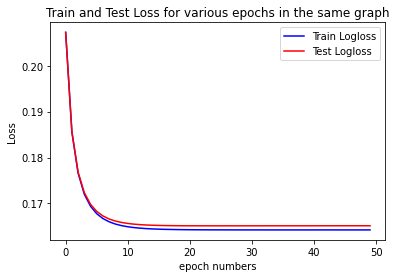

In [68]:
x = np.array([i for i in range(0, 50)])

train_log_loss = np.array(train_loss)
test_log_loss = np.array(test_loss)

plt.plot(x, train_log_loss, "-b", label="Train Logloss")
plt.plot(x, test_log_loss, "-r", label="Test Logloss")

plt.legend(loc="upper right")

plt.xlabel('epoch numbers')
plt.ylabel('Loss')
plt.title('Train and Test Loss for various epochs in the same graph')
plt.show()

Plot epoch number vs train , test loss 

* epoch number on X-axis
* loss on Y-axis

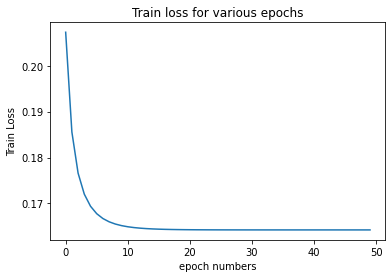

In [69]:
x = np.array([i for i in range(0, 50)])
y = np.array(train_loss)
plt.plot(x, y)
plt.xlabel('epoch numbers')
plt.ylabel('Train Loss')
plt.title('Train loss for various epochs')
plt.show()

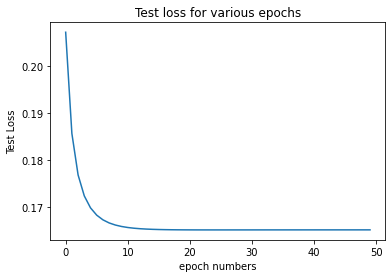

In [70]:
x = np.array([i for i in range(0, 50)])
y = np.array(test_loss)
plt.plot(x, y)
plt.xlabel('epoch numbers')
plt.ylabel('Test Loss')
plt.title('Test loss for various epochs')
plt.show()

In [71]:
def pred(w,b, X):
    N = len(X)
    predict = []
    for i in range(N):
        z=np.dot(w,X[i])+b
        if sigmoid(z) >= 0.5: # sigmoid(w,x,b) returns 1/(1+exp(-(dot(x,w)+b)))
            predict.append(1)
        else:
            predict.append(0)
    return np.array(predict)
print(1-np.sum(y_train - pred(w,b,X_train))/len(X_train))
print(1-np.sum(y_test  - pred(w,b,X_test))/len(X_test))

0.95184
0.94936
